# 9 特徴量エンジニアリング

今回は様々なデータセットを題材として特徴量エンジニアリングについて学びます。

ゴール：特徴量エンジニアリングの手法を学び、適切に使い分けられるようになる。

## 目次
**[9.1 はじめに](#9.1-はじめに)**
> [9.1.1 準備](#9.1.1-準備)
> [9.1.2 特徴量エンジニアリング概要](#9.1.2-特徴量エンジニアリング概要)

**[9.2 数値変数の変換](#9.2-数値変数の変換)**
> [9.2.1 スケーリング](#9.2.1-スケーリング)
> [9.2.2 非線形変換](#9.2.2-非線形変換)
> [9.2.3 交差項の作成](#9.2.3-交差項の作成)

**[9.3 カテゴリ変数のエンコーディング](#9.3-カテゴリ変数のエンコーディング)**
> [9.3.1 Label Encoding](#9.3.1-Label-Encoding)
> [9.3.2 Count Encoding](#9.3.2-Count-Encoding)
> [9.3.3 Label-Count Encoding](#9.3.3-Label-Count-Encoding)
> [9.3.4 One-Hot Encoding](#9.3.4-One-Hot-Encoding)

**[9.4 時間変数のエンコーディング](#9.4-時間変数のエンコーディング)**
> [9.4.1 周期性を考慮しないエンコーディング](#9.4.1-周期性を考慮しないエンコーディング)
> [9.4.2 周期性を考慮したエンコーディング](#9.4.2-周期性を考慮したエンコーディング)

**[9.5 次元削減と特徴選択](#9.5-次元削減と特徴選択)**
> [9.5.1 次元削減](#9.5.1-次元削減)
> [9.5.2 特徴選択](#9.5.2-特徴選択)

## 9.1 はじめに
### 9.1.1 準備
　まず基本的なライブラリの読み込みや、設定を済ませておきます。

In [ ]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
%matplotlib inline

# その他設定
import warnings
warnings.filterwarnings('ignore')

### 9.1.2 特徴量エンジニアリング概要
　特徴量エンジニアリングとは、モデルの学習・予測に効果的な説明変数を作成しようとする試みです。
（説明変数と特徴量はほぼ同義ですが、前者は統計学・後者は機械学習分野での用語となっています。）

特徴量エンジニアリングの取り組みには、大別して二つの方向性があります;
- 問題設定に依らない汎用的な手法を用いるもの
- 問題設定に特有の背景知識に基づくもの

今回は、汎用的な前者の手法の中から、代表的なものをいくつか紹介します。

初めに、数値変数とカテゴリカル変数の違いについて確認しておきましょう。
データの型には、大別して数値変数とカテゴリカル変数の二つがあります;
- 数値変数: 比例尺度・間隔尺度
- カテゴリカル変数: 順序尺度・名義尺度

ほぼ全ての機械学習モデルの実装は、カテゴリカル変数を含むデータに対して学習や予測ができません。
そのため、カテゴリカル変数は予め数値変数に変換しておく必要があります。（エンコーディング）

## 9.2 数値変数の変換
### 9.2.1 スケーリング
数値変数間のスケールが異なる場合、非決定木系のモデルでは適切に学習が行われないことがあります。
そのような場合には、標準化や正規化と呼ばれる変換によって、数値変数に対しスケーリングを施します。

- 標準化:
　平均が0・標準偏差が1になるよう以下のように変換します。
　ただし $\mu_x$ と $\sigma_x$ はそれぞれ $x$ の平均と標準偏差です。
\begin{equation}
x_{std} = \cfrac{x - \mu_x}{\sigma_x}
\end{equation}

- 正規化:
　最小値が0・最大値が1になるよう以下のように変換します。
\begin{equation}
x_{norm} = \cfrac{x - x_{min}}{x_{max} - x_{min}}
\end{equation}

ここではアヤメデータセットを用いて、前者の標準化の適用方法とその使い分けについて見てみましょう。
標準化は上の式に従って簡単に実装できますが、以下のように実装済みのものを利用することもできます。
以下では、`sepal length (cm)` を sklearn.preprocessing.StandardScaler により標準化しています。

In [ ]:
# ライブラリの読み込み
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# データの読み込み
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

# 対象変数の取り出し
x = df[['sepal length (cm)']]

# 標準化器の作成および適用
ss = StandardScaler()
x_std = ss.fit_transform(x)

# 変換前と変換後の値を比較
x['sepal length std'] = x_std
display(x)

# 変換前と変換後の平均と標準偏差を比較
x.describe().loc[['mean', 'std'], :]

,sepal length (cm),sepal length std
0,5.1,-0.900681
1,4.9,-1.143017
2,4.7,-1.385353
3,4.6,-1.506521
4,5.0,-1.021849
...,...,...
145,6.7,1.038005
146,6.3,0.553333
147,6.5,0.795669
148,6.2,0.432165


,sepal length (cm),sepal length std
mean,5.843333,-4.736952e-16
std,0.828066,1.003350e+00


確かに標準化後は、平均が0・標準偏差が1となっています。

アヤメデータセットで、モデルの種類およびスケーリングの有無に関する対照実験を行ってみましょう。
- 説明変数: `sepal length (cm)` (がくの長さ)
- 目的変数: `target` (アヤメの品種, 3クラス)
- モデル: ロジスティック回帰 / 決定木
- 変数変換: 標準化の有無
- 評価指標: 正解率
- 検証方法: ホールドアウト法

In [ ]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# 説明変数と目的変数の用意
X = df[['sepal length (cm)']]
y = df.loc[:, "target"]

# 訓練データと検証データの分割
X_train, X_valid, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# モデルの用意
mods = {
    'LogisticRegression': LogisticRegression(C=0.01, random_state=42),

    'StandardScaler + LogisticRegression': Pipeline([('ss', StandardScaler()), ('model', LogisticRegression(C=0.01, random_state=42))]),

    'DecisonTree': DecisionTreeClassifier(random_state=42),

    'StandardScaler + DecisonTree': Pipeline([('ss', StandardScaler()), ('model', DecisionTreeClassifier(random_state=42))])
}

# モデルの学習と評価
results = {}
for mod_name, mod in mods.items():
    mod.fit(X_train, y_train)
    results[(mod_name, 'train')] = round(accuracy_score(y_train, mod.predict(X_train)), 3)
    results[(mod_name, 'valid')] = round(accuracy_score(y_test, mod.predict(X_valid)), 3)

# 結果の整理
pd.Series(results).unstack().iloc[[1, 3, 0, 2]]

,train,valid
LogisticRegression,0.610,0.533
StandardScaler + LogisticRegression,0.705,0.600
DecisonTree,0.771,0.756
StandardScaler + DecisonTree,0.771,0.756


この結果で押さえておくべき点は次の二つです;
- 上の2行を比較すると、ロジスティック回帰では標準化した方が精度が高くなっています。
- 下の2行を比較すると、決定木では標準化の影響が全く現れていません。

このように標準化は、決定木系のモデルに影響を一切与えません。
一方で非決定木系のモデルには良い影響を与えることがあります。

**<練習問題 1>**
標準化はなぜ決定木系のモデルに影響を与えないのか考えて/調べてみましょう。
（ヒント：決定木系のアルゴリズムでは、変数間のどのような関係が問題となるでしょうか？）

**<練習問題 2>**
今までに開催されたコンペティションのデータを用いて、数値変数のスケーリングの効果を検証してみましょう。

### 9.2.2 非線形変換
スケーリングで見たように、非決定木系のモデルでは数値変数を非線形変換した方が性能が向上することがあります。
主な非線形変換としては対数・平方・平方根などがありますが、今回は対数変換を例にとってその効果を見てみます。

対数変換は、その変数の分布が歪んでいる場合において、それを補正して分布を正規分布に近付けるために用います。
歪んだ分布を対数変換によって正規分布に近付けることにより、機械学習モデルの性能が向上する場合があります。

ここではワインデータセットの一部を用いて、対数変換の有無によるロジスティック回帰の性能の違いを見てみます。
まずは、ワインデータセットの中から以下の二変数の分布と、それを対数変換したものの分布を比較してみましょう。
- color_intensity: 色の濃さ
- malic acid: リンゴ酸濃度

ちなみに今回は問題とはなりませんが、対数変換を適用するためには変換前の変数が全て正値である必要があります。
ゼロ以下の値を含んでいる場合には、最小値+1を加えるなどして変数を平行移動すれば、適用できるようになるます。

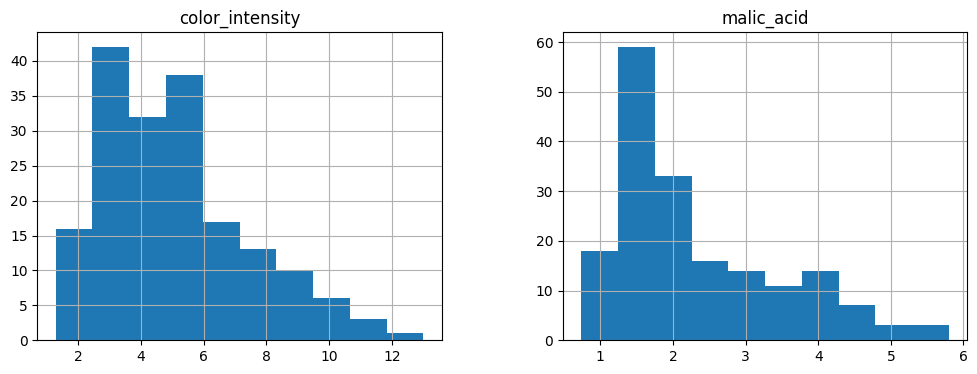

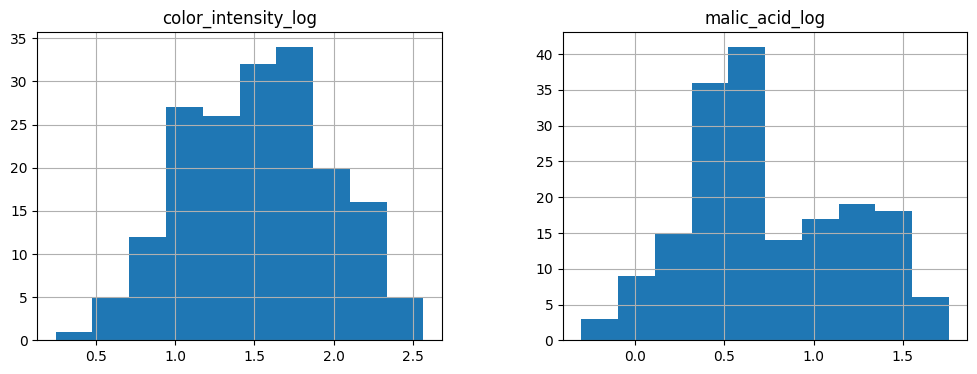

In [ ]:
# ライブラリの読み込み
from sklearn.datasets import load_wine

# データの読み込み
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['variety'] = wine.target

# 対象変数の取り出し
cols = ['color_intensity', 'malic_acid']
X = df[cols]

# 元の分布の表示
X.hist(figsize=(12, 4))

# 対数変換
X_log = np.log(X)
cols_log = [s + '_log' for s in cols]
X_log.columns = cols_log

# 対数変換後の分布の表示
X_log.hist(figsize=(12, 4))
plt.show()

対数変換により、それぞれの分布の歪みが補正されていることがわかります。

これらを説明変数として、ロジスティック回帰の性能を比較してみましょう。
- 説明変数: `color_intensity`, `malic_acid`
- 目的変数: `variety` (ワインの種類, 3クラス)
- モデル: ロジスティック回帰
- 変数変換: 対数変換の有無
- 評価指標: F1スコア
- 検証方法: 5分割交差検証法

In [ ]:
# ライブラリの読み込み
from sklearn.model_selection import cross_val_score

# 目的変数の用意
y = df['variety']

# モデルの作成
mod = LogisticRegression(random_state=42)

# モデルの学習と評価
score_wo_log = cross_val_score(mod, X, y, cv=5, scoring='f1_weighted').mean()
score_w_log = cross_val_score(mod, X_log, y, cv=5, scoring='f1_weighted').mean()

print('CV score w/o log: {:.3f}'.format(score_wo_log))
print('CV score w/ log: {:.3f}'.format(score_w_log))

CV score w/o log: 0.768
CV score w/ log: 0.797


分布の歪んだ変数の対数変換により、ロジスティック回帰の性能が向上しているのがわかります。

スケーリングで見たのと同様に、非決定木系のモデルは適切な非線形変換で性能を向上させます。

**<練習問題 3>**
今までに開催されたコンペティションのデータを用いて、数値変数の非線形変換の効果を検証してみましょう。

### 9.2.3 交差項の作成
数値変数に対する主要な特徴量エンジニアリング手法として、交差項の作成も挙げられます。
交差項とは、複数の変数を掛け合わせて新たに作成される変数を指します。
　例:
\begin{equation}
(x_1, x_2, x_3) \rightarrow (x_1x_2, x_2x_3, x_3x_1)
\end{equation}

交差項を作成する際のデメリットは、変数が増えることで計算コストが大きくなることです。
そのため、後述の特徴選択などの変数を絞る手法と組み合わせて用いられることが多いです。

ここではボストン住宅価格データセットの全ての変数を使って、交差項を作成してみます。

In [ ]:
# Housingデータセットを読み込み
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# DataFrameにデータを格納
X = pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

# 住宅価格の中央値（MEDV）のデータを用意
y = pd.Series(target, name='MEDV')

# Xとyを結合して先頭の5行を表示
X.join(y).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


説明変数は13種類の数値変数から構成されていることがわかります。
これらから交差項を作成すると、${}_{13}\mathrm{C}_2 = 91$ 種類の変数が増えます。
このことを確認してみます。

In [ ]:
# ライブラリの読み込み
from sklearn.preprocessing import PolynomialFeatures

# 交差項作成器の作成
pf = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf = pf.fit_transform(X)

# 結果の確認
print("変数の数: {}".format(X_pf.shape[1]))

変数の数: 91


**<練習問題4>**
今までに開催されたコンペティションのデータを用いて、交差項を作成してみましょう。

## 9.3 カテゴリ変数のエンコーディング
初めに述べたように、カテゴリカル変数は予め数値変数に変換しておく必要がありました。
これをカテゴリカル変数のエンコーディングと言い、次のように様々な手法が存在します;
- Label Encoding
- Count Encoding
- Label-Count Encoding
- One-Hot Encoding（これらの他にも様々あります）

Titanicデータセットのカテゴリカル変数 `embarked`に対して、それぞれの適用方法を見てみましょう。
- `embarked`: 乗船した港、値は `C`, `Q`, `S` の三種類

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# データの読み込み（pathにはコンペティション1の対応するパスを入れてください）
path = "/content/drive/MyDrive/GCI_2023_Summer/Competitions/competition_1/"
df = pd.read_csv(path + 'data/train.csv')

# 対象変数の取り出し
x = df['Embarked']

# 欠損値補完（最多の'S'で補完します）
x.fillna('S', inplace=True)

# 対象変数の確認
x.head(10)

### 9.3.1 Label Encoding
Label Encodingでは、与えられたカテゴリカル変数に単純に数字を割り当てることでエンコーディングします。
　例: `C` → 0, `Q` → 1, `S` → 2

この手法の問題点は、3種類以上の値を含むカテゴリカル変数に対して、無意味な順序が導入されてしまうことです。
（例: CとQの差よりCとSの差の方が大きいということはないが、数値的にはそのようなことが含意されてしまう）

In [ ]:
# ライブラリの読み込み
from sklearn.preprocessing import LabelEncoder

# Label Encoding器の作成
le = LabelEncoder()

# Label Encodingの適用
x_le = le.fit_transform(x)

# 適用結果の確認（最初の10件）
x_le[:10]

### 9.3.2 Count Encoding
これに対してCount Encodingでは、与えられたカテゴリカル変数にそれぞれの値の出現回数を割り当てます。
　例: `C`, `Q`, `S`の出現回数がそれぞれ168, 77, 644であれば、`C` → 168, `Q` → 77, `S` → 644

この手法の問題点は、異なるカテゴリカル変数に同じ値が割り当てられ、情報が失われる場合があることです。
（例: `C`, `Q`の出現回数がそれぞれ1であれば、`C` → 1, `Q` → 1となり、同じ値になってしまう）

In [ ]:
# Count Encodingの適用
x_ce = x.map(x.value_counts())

# 適用結果の確認（最初の10件）
x_ce[:10]

### 9.3.3 Label-Count Encoding
Label-Count Encodingはその名の通り Label Encoding と Count Encoding を組み合わせたものです。
Label-Count Encodingでは、与えられたカテゴリカル変数にそれぞれの値の出現回数の順位を割り当てます。
　例: `C`, `Q`, `S`の出現回数がそれぞれ168(2位), 77(3位), 644(1位)であれば、`C` → 2, `Q` → 3, `S` → 1

Label-Count Encodingは、無意味な順序付けというLabel Encodingの問題点を解消する手法となっています。

また出現回数が同じ場合に順位を登場順に決めることにすれば（rankメソッドの引数をmethod='first'とする）
異なるカテゴリカル変数に対する値の衝突というCount Encodingの問題点も解消することができています。
（ただしこの場合、出現回数が同じカテゴリカル変数だけに対しては、無意味な順序が導入されてしまいます）

In [ ]:
# Label-Count Encodingの適用
x_lce = x.map(x.value_counts().rank(ascending=False, method='first'))

# 適用結果の確認（最初の10件）
x_lce[:10]

### 9.3.4 One-Hot Encoding
One-Hot Encodingは、カテゴリカル変数のそれぞれの値に対応するカラムを用意して、フラグを割り当てます。
この手法は、Label EncodingやCount Encodingで挙げられた問題点をいずれも解消することができています。

例:

|　index　|　Embarked　|　|→|　|　index　|　S　|　C　|　Q　|
|:-:|:-:|---|---|---|:-:|:-:|:-:|:-:|
|1 |S ||||1|1|0|0|
|2 |C ||||2|0|1|0|
|3 |S ||||3|1|0|0|
|4 |S ||||4|1|0|0|
|5 |S ||||5|1|0|0|
|6 |Q ||||6|0|0|1|

One-Hot Encodingの問題点は、カテゴリカル変数の値の種類だけカラム数が増え、疎になってしまうことです。
例えば1000種類の値をもつ変数に対してOne-Hot Encodingを適用すると、カラムが1000列増えてしまいます。
このような場合は、前述のLabel-Count Encodingなど他の手法を適用した方が良いということになるでしょう。

In [ ]:
# One-Hot Encodingの適用
x_ohe = pd.get_dummies(x)

# 適用結果の確認（最初の10件）
x_ohe[:10]

**<練習問題5>**
今までに開催されたコンペティションのデータを用いて、様々なエンコーディングを適用してみましょう。

## 9.4 時間変数のエンコーディング
時間や日付のように数値でも周期性をもつ変数は、その構造を反映した形でエンコードする必要があります。
ここでは日付を例にとって、時間変数のエンコーディング手法を見ていきましょう。

まずここで扱うサンプルデータとして、2010年代の日付をランダムに10個取得します。

In [ ]:
import datetime
import random

# startとendの間のランダムな日付を出力する関数
def generate_rand_date(start, end):
    days_delta = (end - start).days
    return start + datetime.timedelta(days=random.randint(0, days_delta))

# 乱数シードを固定して、2010年代の日付をランダムに10個取得
random.seed(0)
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 12, 31)
random_dates = [generate_rand_date(start, end) for _ in range(10)]

# 日付データをDataFrame化
df_dates = DataFrame(random_dates, columns=['ymd'])
df_dates

,ymd
0,2019-06-21
1,2014-04-27
2,2018-07-02
3,2019-12-26
4,2014-09-19
5,2010-06-15
6,2012-11-26
7,2020-10-29
8,2015-09-26
9,2015-06-14


### 9.4.1 周期性を考慮しないエンコーディング
まずは、周期性を考慮しないエンコーディング手法をいくつか見てみましょう。

最も単純なエンコーディング手法は年月日それぞれを数値変数とする方法です。


In [ ]:
# 年月日を、年・月・日に分割
df_dates['year'] = df_dates['ymd'].apply(lambda x: x.year)
df_dates['month'] = df_dates['ymd'].apply(lambda x: x.month)
df_dates['day'] = df_dates['ymd'].apply(lambda x: x.day)

df_dates

,ymd,year,month,day
0,2019-06-21,2019,6,21
1,2014-04-27,2014,4,27
2,2018-07-02,2018,7,2
3,2019-12-26,2019,12,26
4,2014-09-19,2014,9,19
5,2010-06-15,2010,6,15
6,2012-11-26,2012,11,26
7,2020-10-29,2020,10,29
8,2015-09-26,2015,9,26
9,2015-06-14,2015,6,14


このようにすることで、年月日それぞれを数値変数として扱うことができるようになりました。
しかしこのような手法に対しては以下のように、大きく二つの問題点を挙げることができます。
1. 年・月・日の情報がバラバラであり時系列的な新旧の学習が困難
(例: 2010年1月1日と2020年1月1日が時系列的に離れているということを表現できていない)
2. 時系列として連続的であるべき部分に断絶が生じてしまっている
(例: 1月と12月、1日と31日がそれぞれ周期的な意味で近いということを表現できていない)

前者に対処するためには、基準時点との差分を新たな変数とする手法を用いることができます。
このようにエンコードすることで、日付の新旧という情報を表すことができるようになります。
今回は日付を扱っているので2010年1月1日を基準日とし、差分を新たな変数としてみましょう。

In [ ]:
# 基準日を2010年1月1日に設定
start_date = pd.Timestamp('2010-01-01 00:00:00')

# 基準日との差分を格納
df_dates['total_days'] = df_dates['ymd'].apply(lambda x: (x - start_date).days)

df_dates

,ymd,year,month,day,total_days
0,2019-06-21,2019,6,21,3458
1,2014-04-27,2014,4,27,1577
2,2018-07-02,2018,7,2,3104
3,2019-12-26,2019,12,26,3646
4,2014-09-19,2014,9,19,1722
5,2010-06-15,2010,6,15,165
6,2012-11-26,2012,11,26,1060
7,2020-10-29,2020,10,29,3954
8,2015-09-26,2015,9,26,2094
9,2015-06-14,2015,6,14,1990


このようにすることで、時系列的な新旧の情報を明示的にエンコードすることができました。
次に周期性を考慮したエンコーディング手法も用いることで、後者の問題に対処しましょう。

### 9.4.2 周期性を考慮したエンコーディング
時間変数の周期的な構造をエンコードするためには、三角関数を用いることができます。
月や日といった周期性をもつものを単位円周上の点に対応づけて、各点の座標で表します。
このとき各点の座標は$\cosと\sin$で表されるので、これらを新たな数値変数として用います。

In [ ]:
df_dates['month_cos'] = df_dates['month'].apply(lambda x: np.cos(2*np.pi * x/12))
df_dates['month_sin'] = df_dates['month'].apply(lambda x: np.sin(2*np.pi * x/12))

df_dates['day_cos'] = df_dates['day'].apply(lambda x: np.cos(2*np.pi * x/31))
df_dates['day_sin'] = df_dates['day'].apply(lambda x: np.sin(2*np.pi * x/31))

df_dates

,ymd,year,month,day,total_days,month_cos,month_sin,day_cos,day_sin
0,2019-06-21,2019,6,21,3458,-1.000000e+00,1.224647e-16,-0.440394,-0.897805
1,2014-04-27,2014,4,27,1577,-5.000000e-01,8.660254e-01,0.688967,-0.724793
2,2018-07-02,2018,7,2,3104,-8.660254e-01,-5.000000e-01,0.918958,0.394356
3,2019-12-26,2019,12,26,3646,1.000000e+00,-2.449294e-16,0.528964,-0.848644
4,2014-09-19,2014,9,19,1722,-1.836970e-16,-1.000000e+00,-0.758758,-0.651372
5,2010-06-15,2010,6,15,165,-1.000000e+00,1.224647e-16,-0.994869,0.101168
6,2012-11-26,2012,11,26,1060,8.660254e-01,-5.000000e-01,0.528964,-0.848644
7,2020-10-29,2020,10,29,3954,5.000000e-01,-8.660254e-01,0.918958,-0.394356
8,2015-09-26,2015,9,26,2094,-1.836970e-16,-1.000000e+00,0.528964,-0.848644
9,2015-06-14,2015,6,14,1990,-1.000000e+00,1.224647e-16,-0.954139,0.299363


このようにすることで、周期的な構造を踏まえて時間変数をエンコードすることができました。

## 9.5 次元削減と特徴選択
元々の説明変数が多かったり、特徴量エンジニアリングで変数が増えたりすると、計算コストが大きくなります。
このように計算コストが問題となったりモデルの説明性が求められるような場合、変数を減らす必要があります。
変数を減らす手法には、次元削減と特徴選択があります。ここでは、そのそれぞれの代表的な手法を紹介します。

### 9.5.1 次元削減
教師なし学習の章で学んだPCA（主成分分析）は、説明変数の次元削減に応用することができます。
PCAを用いた次元削減は、次のように実行できます;

1. 変数をスケーリングする
2. PCAを施す
3. 寄与率などを参考に変換後の変数を絞る

ここでは乳がんデータセットを用い、PCAによりデータの次元を元の30次元から削減してみます。
ただしPCAを適用した後の変数は、累積寄与率がおおよそ80%となるように次元削減を行います。

In [ ]:
# ライブラリの読み込み
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

# データの読み込み
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

# 説明変数の取り出し
X = df.iloc[:, :-1]

# スケーリング
ss = StandardScaler()
X_std = ss.fit_transform(X)

# PCAの適用
pca = PCA()
X_pca = pca.fit_transform(X_std)

# 累積寄与率の確認
ev_ratio = pca.explained_variance_ratio_
ev_ratio = ev_ratio.cumsum().round(3)
ev_ratio

array([0.443, 0.632, 0.726, 0.792, 0.847, 0.888, 0.91 , 0.926, 0.94 ,
       0.952, 0.961, 0.97 , 0.978, 0.983, 0.986, 0.989, 0.991, 0.993,
       0.995, 0.996, 0.997, 0.997, 0.998, 0.999, 0.999, 1.   , 1.   ,
       1.   , 1.   , 1.   ])

この結果から第4主成分までを採用すれば、累積寄与率がおよそ0.8となることがわかります。
つまりこの累積寄与率0.8の基準であれば、次元を元の30次元から4次元まで削減できました。

ついでに、第1主成分と第2主成分を用いてデータを二次元平面上にプロットしてみましょう。

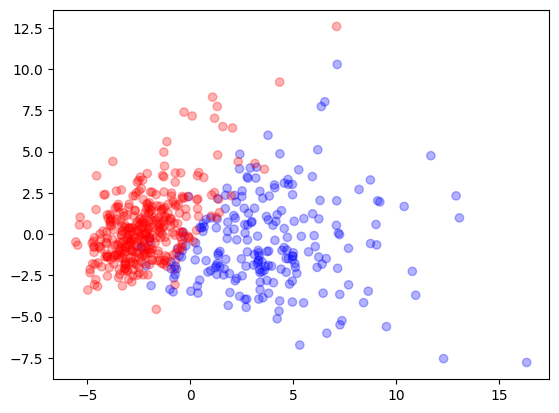

In [ ]:
# 目的変数の取り出し
y = df.iloc[:, -1]

# 散布図を表示
color_list = list(map(lambda x: ['b', 'r'][x], y))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, color=color_list)

**<練習問題6>**
元のデータで学習させたモデルの性能と、PCAで次元削減したモデルの性能を比較してみましょう。

**<練習問題7>**
今までに開催されたコンペティションのデータに対して、PCAによる次元削減を行ってみましょう。

### 9.5.2 特徴選択
PCAによる次元削減では変数を主成分に変換した上で、寄与率に基づいて絞り込みました。
一方、特徴選択では、変数をそのままに、回帰係数や変数重要度に基づいて絞り込みます。
そのため、特徴選択では回帰係数や変数重要度を出力できるモデルを与える必要があります。
- 回帰: ランダムフォレスト回帰、リッジ回帰 etc.
- 分類: ランダムフォレスト分類、ロジスティック回帰 etc.

ここでは2.3の交差項の作成で大量に作成されてしまった変数を10個に絞り込みましょう。
設定するモデルは、変数重要度の出力が可能であるランダムフォレスト回帰モデルとします。

In [ ]:
# ライブラリの読み込み
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# データの読み込み
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# 説明変数と目的変数の用意(実行に時間がかかるため、最初の100行を使用)
X = pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])[:100]
y = pd.Series(target, name='MEDV')[:100]

# 交差項作成器の作成
pf = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# 交差項の作成
X_pf = pf.fit_transform(X)

# 説明変数の結合
X_all = X.join(DataFrame(X_pf))

# カラムでint型とstr型が混在しているため、str型に統一
X_all.columns = X_all.columns.astype(str)

# 特徴選択器の作成
rfr = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rfr, n_features_to_select=10)

# 特徴選択の実行
rfe.fit(X_all, y)

# 結果の確認
X_rfe = X_all.loc[:, rfe.support_]
X_rfe.head()

,RM,5,45,62,67,68,73,75,87,89
0,6.575,6.575,11.5038,2.67924,100.5975,2609.61750,997.56,324.696,1474.08,76.194
1,6.421,6.421,64.6198,4.28666,114.2938,2548.49490,1404.42,721.146,2211.88,162.692
2,7.185,7.185,28.4921,1.89007,127.8930,2822.48355,1087.58,246.233,975.26,71.734
3,6.998,6.998,6.4092,1.34652,130.8626,2761.62074,856.46,134.652,652.68,54.978
4,7.147,7.147,11.6194,2.44114,133.6489,2836.64430,1013.54,288.886,1183.26,99.671


このようにして、104種類あった変数を10種類まで選択することができました。

**<練習問題8>**
元データ・交差項追加データ・特徴選択データそれぞれで、モデルの性能と学習時間を比較してみましょう。

**<練習問題9>**
今までに開催されたコンペティションのデータに対して、特徴選択を行ってみましょう。

**謝辞**：以下のデータセットの利用に関して利用に関して
1. http://lib.stat.cmu.edu/datasets/boston

引用元：The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978. Used in Belsley, Kuh & Welsch, 'Regression Diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980.